# Home Credit Default Risk

In [70]:
from IPython.display import Image
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

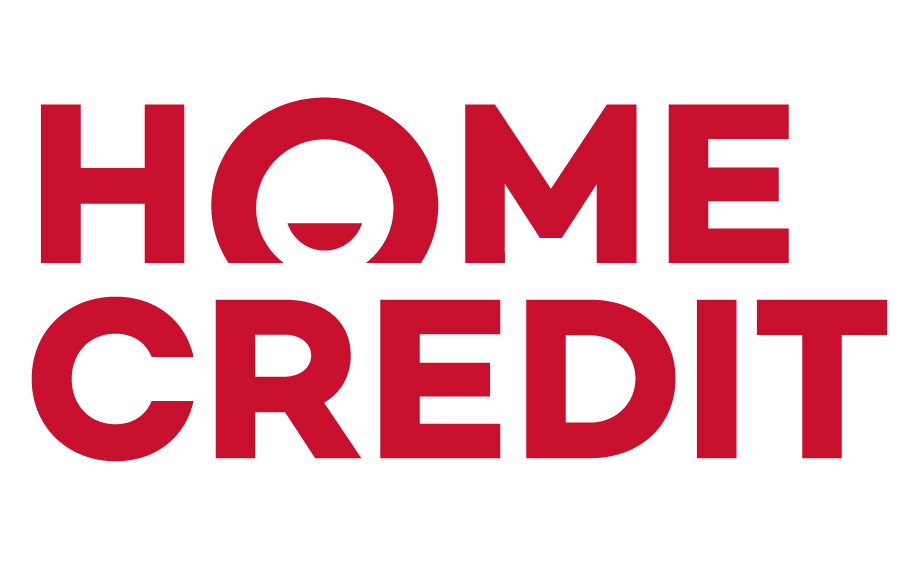

In [2]:
Image("Home-Credit-logo.jpg")

## Introduction


### Business Context 

Credit stablisment exists to loan money to their customers. The financial system function as a lubricant for the society. Largely, they collect money and allocate it in, primarly, credits. Nonetheless allocate this resources wisely are true headache for the banking system, I mean, not a simple headache, is a migrane. 
Sometimes this problem is occasioned by a gap in the financial information, either not enough credit history or lack of it. And, unfortunately, this population is often taken advantage of by untrustworthy lenders that operates illegally and can comission whatever they want. 

[Home Credit](https://www.homecredit.net/) strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. As shown in the main page of Home Credit:

"*Our responsible lending model empowers underserved customers with little or no credit history by enabling them to borrow easily and safely, both online and offline*" 


### Business Problem 

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

Credit lending has to be well-balanced in orther to charge an appropiate fee. Risky loans has to have a higher fee relative to safer loans, in part for provisions (money storage my the lender in a secure account that the regulators demand for each loan) 
and to absorb to possible scenario of a default (risk and return philosophy: Higher risk derive higher return).

This is where Artificial Intelligence, especially Machine Learning models, play a vital role. These algorithms have the capacity to learn from historical data, i.e. find patterns of the group of customer whom previosly defaulted and accurately return an score (probability). This credit default risk is what is then used to determine the interest rate in the loan.


### Analytical Context

As stated before, this is the perfect problem for a Machine Learning algorithm. 
Specifically, this machine learning task has the following characteristics:

- Supervised model: The data is labeled and we're aiming to predict the repayment probability of a loan.

- Binary clasification: This is referred to how many distinct categories does the objective variable has. In this case there are 2: Default (1) or not (0) 

### Table of content:
* [Section 1: Functions](#functions)
* [Section 2: Exploratory Data Analysis](#eda)
    * [Section 2.1: General view of application_train dataframe](#general)
    * [Section 2.2: Description dataframe](#description)
    * [Section 2.3: Float variables](#float)
    * [Section 2.4: Categorical variables](#categorical)
    * [Section 2.5: Integer variables](#int)
    * [Section 2.6: Correlations](#corr)
    * [Section 2.7: Missing values](#missing_values)
    * [Section 2.8: Feature Engineering](#feature_engineering)
* [Section 3: Modeling](#modeling)
    * [Section 3.1: Dummy variables](#dummies)
    * [Section 3.2: Train test split](#train_test)
    * [Section 3.3: Training](#training)
    * [Section 3.1: Feature importance](#feature_importance)
* [Section 4: Conclusions](#conclusions)
* [Section 5: Resources](#resources)
    
    

Installing missingno package

In [3]:
!pip install missingno

- Packages

In [90]:
# Data manipulation
import pandas as pd
import numpy as np
import math

# Data visualization
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

# Other
import shutil
columns = shutil.get_terminal_size().columns
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

- Data

In [97]:
# Importing the data
description = pd.read_csv('HomeCredit_columns_description.csv', encoding= 'unicode_escape')[['Table','Row', 'Description']]
application_test = pd.read_csv('application_test.csv')

application_train_1 = pd.read_csv('application_train_1.csv')
application_train_2 = pd.read_csv('application_train_2.csv')
application_train = pd.concat([application_train_1,application_train_2])

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Overview of the datasets:

- **description**: Dataset containing the details about every column across all datasets.
- **application_train**: This is the dataset were all the analysis was established.
- **application_test**: Dataset for submission in Kaggle. If the model wants to be scored with in kaggle, this table has all the same columns that *application_train* but without the target variable.

An analysis of the target variable is found later on this project. However is worth mentioning that the response variable is named *TARGET*

### Functions  <a class="anchor" id="functions"></a>

In [6]:
def missing_values(df):
    '''
    INPUT:
    df (dataframe): The dataframe
    
    OUTPUT:
    porc_null (dataframe): index = Columns in the dataframe
                           Value counts = Number of missing points
                           Percentage = Percentage over all the data with missing values
    
    DESCRIPTION:
    This function returns a dataframe with the columns as index, the value counts with missing values and 
    the respective percentage
    '''
    
    # Get the null values    
    porc_null = pd.DataFrame(df.isnull().sum(axis = 0) * 100 / df.shape[0])
    
    # Sorted values and order
    porc_null = porc_null.rename(columns = {0:'Percentage'})
    
    # Value counts
    porc_null['Value counts'] = list(df.isnull().sum(axis = 0))
    
    # Ordering the columns
    porc_null = porc_null[['Value counts','Percentage']].sort_values(by = 'Value counts', ascending = False)
    
    # Print statment
    print('There are {} columns with null values'.format(len(porc_null.loc[porc_null.Percentage == 0,'Percentage'])))
        
    return porc_null

In [7]:
def plot_numerical(list_variables, df = application_train, nrows = 20, ncols = 2):
    '''
    INPUT
    df (dataframe): application_train dataset
    list_variables (list): A list with the numerical columns for plotting
    nrows (int): Number of rows
    ncols (int): Number of columns
    
    OUTPUT
    
    DESCRIPTION
    This function plots the distribution of the list_variables with respect to the target variable
    
    '''
    # Filtering the data
    target_0 = df.loc[df.TARGET == 0,:]
    target_1 = df.loc[df.TARGET == 1,:]
    
    # Plotting
    ax=plt.subplots(ncols,ncols,figsize=(22,15))
    sns.set_style('whitegrid')

    for i, variable in enumerate(list_variables):
        plt.subplot(nrows,ncols,i+1)

        sns.distplot(target_0[variable], label = 'Target = 0', rug=False, hist=False)
        sns.distplot(target_1[variable], label = 'Target = 1', rug=False, hist=False)
        plt.title(variable, fontsize = 16)
        plt.legend()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')        
    plt.show();

In [8]:
def plot_categorical(list_variables, many_categories = False, rotate_xlabel = False, nrows = 2, ncols = 2, length = 15, height = 14):
    '''
    INPUT:
    list_variables (list or str): If the variables to plot have less than 3 categories then a list can be passed.
                                  If the variable has more of 3 categories, it's preferable to graph only that variable
    many_categories (bool): True if the variable has many categories false otherwise
    rotate_xlabel (bool): True if it's desire to rotate xticks
    nrows (int): Number of rows for the subplots
    ncols (int): Number of columns for the subplots
    length (int): Lenght of the plot
    height (int): Height of the plot
    
    OUTPUT:
    
    DESCRIPTION:
    This function create a barplot for the columns inputted
    '''
    
    var = None
    target_0 = application_train.loc[application_train.TARGET == 0,:]
    target_1 = application_train.loc[application_train.TARGET == 1,:]
    
    if (many_categories):
        
        var = list_variables
        plt.figure(figsize=(15,10))       

        df0 = target_0.loc[:,var].value_counts(normalize = True).reset_index()
        df0.loc[:,'target'] = 0

        df1 = target_1.loc[:,var].value_counts(normalize = True).reset_index()
        df1.loc[:,'target'] = 1

        df3 = pd.concat([df1,df0])

        sns.barplot(data = df3, x = 'index', y = var, hue = 'target', palette="pastel", edgecolor=".6")
        plt.title(var, fontsize = 16)
        plt.ylabel('Percentage')
        plt.xlabel('')
        plt.xticks(rotation = 70)
        plt.show();
        
    else:
        
        fig = plt.figure(figsize=(length,height))
        
        for i, var in enumerate(list_variables):

            fig.tight_layout()
            plt.subplot(nrows,ncols,i+1)
            plt.subplots_adjust(wspace=0.2)
            
            df0 = target_0.loc[:,var].value_counts(normalize = True).reset_index()
            df0.loc[:,'target'] = 0

            df1 = target_1.loc[:,var].value_counts(normalize = True).reset_index()
            df1.loc[:,'target'] = 1

            df3 = pd.concat([df0,df1])

            sns.barplot(data = df3, x = 'index', y = var, hue = 'target', palette="pastel", edgecolor=".6")
            plt.title(var,  fontsize = 16)
            plt.ylabel('Percentage')
            plt.xlabel('')

            if (rotate_xlabel):
                plt.xticks(rotation = 70)
        plt.show(); 

In [9]:
def plot_integer(list_variables, df = application_train, nrows = 5, ncols = 2):
    '''
    INPUT
    list_variables (list): A list of integer columns to plot
    df (dataframe): Dataframe
    nrows (int): Number of rows
    ncols (int): Number of columns
    
    OUPUT
    
    DESCRIPTION
    This function plot integer columns
    '''
    # Filtering the data
    target_0 = df.loc[df.TARGET == 0,:]
    target_1 = df.loc[df.TARGET == 1,:]

    # Plotting
    fig, ax=plt.subplots(nrows,ncols,figsize=(22,20))
    sns.set_style('whitegrid')

    for i, variable in enumerate(list_variables):
        plt.subplot(nrows,ncols,i+1)
        plt.subplots_adjust(wspace=0.2)
        fig.tight_layout()

        sns.kdeplot(target_0[variable], label = 'Target = 0')
        sns.kdeplot(target_1[variable], label = 'Target = 1')
        plt.title(variable, fontsize = 16)
        plt.legend()
        plt.yticks([])
        plt.xlabel('')        
    plt.show();

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

### General view of the dataframe <a class="anchor" id="general"></a>

Firstly, let's answer some questions: 
1. ¿Is there any duplicated ids?
2. ¿How many loans and columns are in the dataset?
3. ¿How many and in what format are the variables in the dataset?
4. ¿Any Missing values? 

In [10]:
print("There are {} duplicated IDs in the dataframe".format((application_train.SK_ID_CURR.value_counts() != 1).sum()))

There are 0 duplicated IDs in the dataframe


In [11]:
print('The data has {} loans and {} variables'.format(application_train.shape[0], application_train.shape[1]))

The data has 307511 loans and 122 variables


In [12]:
dtypes = application_train.dtypes.value_counts()

for dtype in dtypes.index:
    print('There are {} variables with {} format'.format(dtypes[dtypes.index == dtype][0], dtype))

There are 65 variables with float64 format
There are 41 variables with int64 format
There are 16 variables with object format


In [13]:
missing_values(application_train)

There are 55 columns with null values


,Value counts,Percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


There are 55 columns with null values


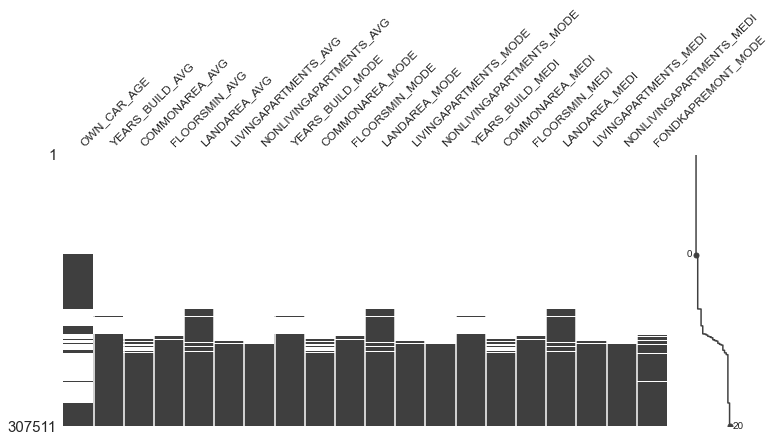

In [93]:
# Visualizing the distribution of the top 20 variables with most missing values

missing_values_df = missing_values(application_train)
missing_values_index = list(missing_values_df.loc[missing_values_df.Percentage != 0].index)[:20]
missing_values_df = application_train.loc[:,application_train.columns.isin(missing_values_index)]

missingno.matrix(missing_values_df, sort="ascending", figsize=(12,5), fontsize=12);

The previous plot is one way of representing the missing data in the dataframe. In the x-axis we locate the top 20 variables with missing values and the y-axis is all the row in the dataframe. If there is missing value a white rectangle will appear, black otherwise.

This kind of graph is usefull in detecting not the percentage of missing value in the column (missing_value function takes that part), but to visualize if the missing data have a pattern. For example, in this analysis, it's shown that if one column has missing value, it will be likely that has missing values in other columns as well. Without taking into account the OWN_CAR_AGE variable, this hypothesis seems valid.

### Description dataframe <a class="anchor" id="description"></a>

Now, lets see what kind of information has the most missing values

In [15]:
description.head()

,Table,Row,Description
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample
1,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,application_{train|test}.csv,CODE_GENDER,Gender of the client
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car


The description dataframe has the explanations of all variables across the tables. Thus, first we have to filtered to only get back the description of the columns in application_train dataset

In [16]:
# Filtering the dataset
description_train = description.loc[description.Table.str.contains('train')][['Row','Description']]
description_train.head()

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car


Now that we have the necessary data, lets get the description of the top 20 variables with most missing values

In [17]:
# Description of the variables with most missing data
description_train.loc[description_train.Row.isin(list(missing_values_df.columns))]['Description'].unique()

array(["Age of client's car",
       'Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor'],
      dtype=object)

Sadly (and inexplicably) the columns that has the most missing value are the variabes associate with the buildings: 
- YEARS_BUILD_AVG
- COMMONAREA_AV
- LIVINGAPARTMENTS_AVG
- LANDAREA_MODE
- ...

If the loan is a mortgage, ¿why are some features with statistics? For example, YEARS_BUILD_AVG doesn't require to have mean, it's just the year where the building was raised. 
Nevertheless, it's a challenge to gather, verify and maintain information. 

This type information (YEAR_BUILD, LIVING_AREA among others) is required in order to obtain the loan, but probably what happened is that the information got lost while the company upgrade/modify the storage capacity, or simply this information resides in a table that someone created years ago and then this data engineer left and nobody knew this dataset existed. It's not a cliche that *'reality surpasses fiction'*.

Momentarily, we're going to keep those variables around because they might have some statistical significance, even though there majority of the rows are missing values

In [18]:
application_train.select_dtypes(include = ['object']).apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

There are only 4 variables with 2 unique values. With the remainder variables it would be appropiate to determine if an aggregation is possible.

- **Distribution of the target variable**

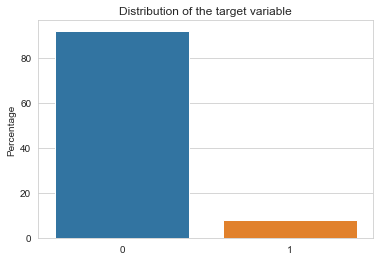

In [19]:
target = application_train.TARGET.value_counts(normalize = True)

sns.barplot(x = target.index, y = target.values*100)
plt.title('Distribution of the target variable')
plt.ylabel('Percentage');

The target variable is, as expected, highly imbalanced. 

Statistically speaking, an imbalanced data is a headache for data scientist due to several problems: for example the algorithm will tend to predict all the values to be the majority class, accuracy as a metric will feal tremendously. Hypothetically, lets suppose we choose accuracy as a follow up metric, if the algorithm estimate all the loans will not default, the accurracy will be **91% !**. 91% for a model that isn't a model.

Alternatively, having a highly imbalanced dataset is healthy for the business. It means that a small proportion of the loans defaults. In other words, if the loan goes into default, the capital that Home Credit lended to the borrower will likely be lost (not taking into account the collection area of the bank or that the bank will likely sell this loan to other company with a discount price) 

- Now let's plot some variables

Before plotting, I hand-picked the columns names with float64 format.

It wasn't done with a python function because it takes a long time to process it.

In [20]:
float_variables = ['AMT_INCOME_TOTAL',                 
                    'AMT_CREDIT' ,                      
                    'AMT_ANNUITY',                     
                    'AMT_GOODS_PRICE',
                    'REGION_POPULATION_RELATIVE',
                    'OWN_CAR_AGE',   
                    'EXT_SOURCE_1',                     
                    'EXT_SOURCE_2',                     
                    'EXT_SOURCE_3',                    
                    'APARTMENTS_AVG' ,                  
                    'BASEMENTAREA_AVG',                 
                    'YEARS_BEGINEXPLUATATION_AVG',     
                    'YEARS_BUILD_AVG',                  
                    'COMMONAREA_AVG',                   
                    'ELEVATORS_AVG' ,                   
                    'ENTRANCES_AVG' ,                   
                    'FLOORSMAX_AVG',                    
                    'FLOORSMIN_AVG',                    
                    'LANDAREA_AVG' ,                    
                    'LIVINGAPARTMENTS_AVG' ,            
                    'LIVINGAREA_AVG',                   
                    'NONLIVINGAPARTMENTS_AVG' ,         
                    'NONLIVINGAREA_AVG' ,               
                    'APARTMENTS_MODE',                  
                    'BASEMENTAREA_MODE',                
                    'YEARS_BEGINEXPLUATATION_MODE',     
                    'YEARS_BUILD_MODE',                 
                    'COMMONAREA_MODE',                  
                    'ELEVATORS_MODE',                   
                    'ENTRANCES_MODE',                   
                    'FLOORSMAX_MODE',                   
                    'FLOORSMIN_MODE',                   
                    'LANDAREA_MODE' ,                   
                    'LIVINGAPARTMENTS_MODE' ,           
                    'LIVINGAREA_MODE',                  
                    'NONLIVINGAPARTMENTS_MODE',         
                    'NONLIVINGAREA_MODE',               
                    'APARTMENTS_MEDI',                  
                    'BASEMENTAREA_MEDI',                
                    'YEARS_BEGINEXPLUATATION_MEDI',     
                    'YEARS_BUILD_MEDI' ,                
                    'COMMONAREA_MEDI',                  
                    'ELEVATORS_MEDI',                   
                    'ENTRANCES_MEDI',                   
                    'FLOORSMAX_MEDI',                   
                    'FLOORSMIN_MEDI',                   
                    'LANDAREA_MEDI',                    
                    'LIVINGAPARTMENTS_MEDI'  ,          
                    'LIVINGAREA_MEDI',                  
                    'NONLIVINGAPARTMENTS_MEDI',         
                    'NONLIVINGAREA_MEDI',
                    'TOTALAREA_MODE',  
                    'OBS_30_CNT_SOCIAL_CIRCLE',         
                    'DEF_30_CNT_SOCIAL_CIRCLE',         
                    'OBS_60_CNT_SOCIAL_CIRCLE',         
                    'DEF_60_CNT_SOCIAL_CIRCLE',         
                    'DAYS_LAST_PHONE_CHANGE',
                    'AMT_REQ_CREDIT_BUREAU_HOUR' ,      
                    'AMT_REQ_CREDIT_BUREAU_DAY',        
                    'AMT_REQ_CREDIT_BUREAU_WEEK',       
                    'AMT_REQ_CREDIT_BUREAU_MON' ,       
                    'AMT_REQ_CREDIT_BUREAU_QRT',        
                    'AMT_REQ_CREDIT_BUREAU_YEAR' ]

In [21]:
print('There are {} float variables'.format(len(float_variables)))

There are 63 float variables


In [22]:
variables_interest_float = ['ENTRANCES_MEDI',
                            'YEARS_BUILD_AVG',
                            'LANDAREA_AVG',
                            'LIVINGAREA_AVG',
                            'AMT_ANNUITY',
                            'AMT_GOODS_PRICE',
                            'AMT_CREDIT',
                            'EXT_SOURCE_1',
                            'EXT_SOURCE_2',
                            'EXT_SOURCE_3',
                            'DEF_30_CNT_SOCIAL_CIRCLE',
                            'OBS_30_CNT_SOCIAL_CIRCLE']

After reviewing all 63 float-format variables, 12 columns were chosen to examine in this project.
This variables were selected regarding the possibly explanation power for the business problem. 

### Float distribution variables <a class="anchor" id="float"></a>

**1.** First 10 float variable in the *variables_interest_float* list

                          First 10 float variables 

                           


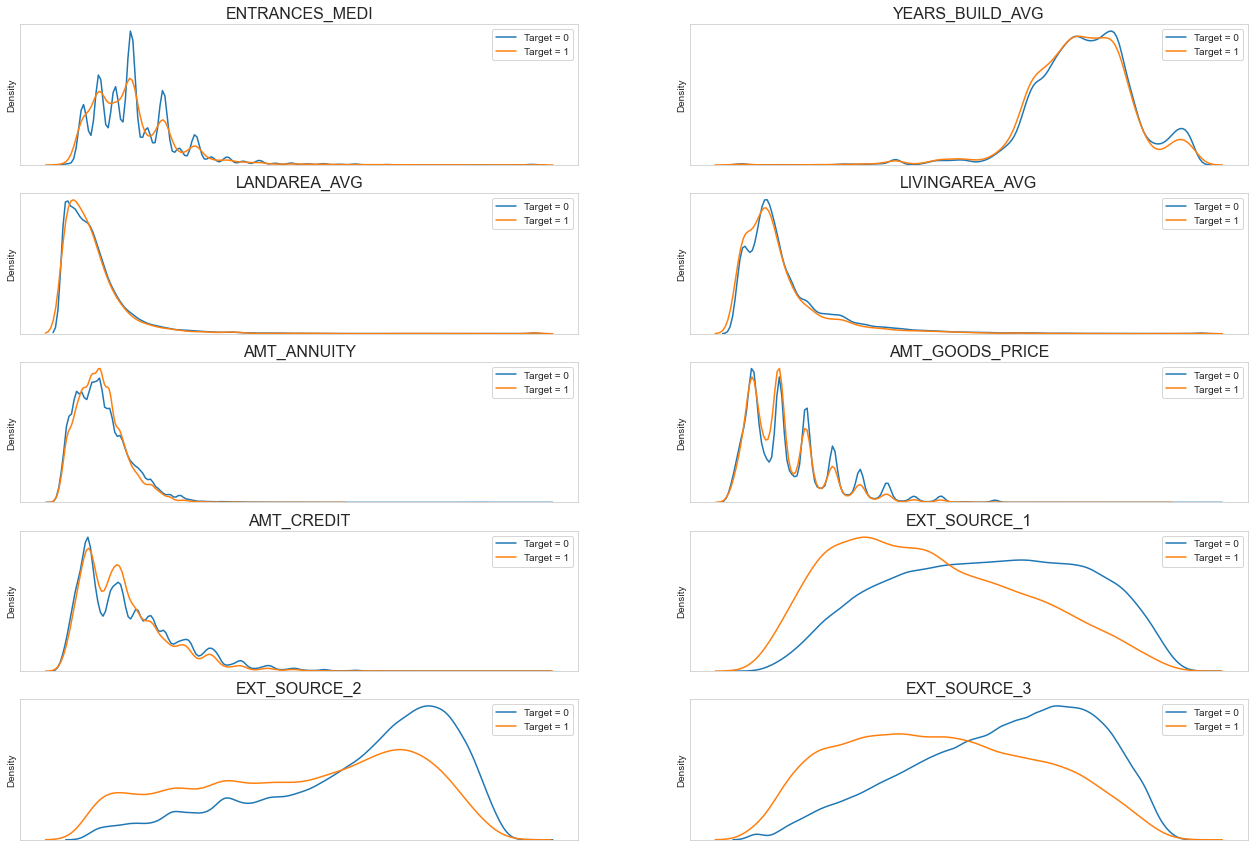

In [94]:
# First 10 float variables
list_variables = variables_interest_float[:10]

print('First 10 float variables \n\n'.center(columns))
plot_numerical(list_variables, nrows = 5, ncols = 2)

The idea behind this graphs is to show the difference in the distribution (partitioned by the target variable) within the variable.

**Insights**:

- Most of the variables have similar distribution, so it's questionable the statistical significance.
- EXT_SOURCE_1, EXT_SOURCE_2 and EXT_SOURCE_3 seems to be significant variables in predicting whetever the loan is goes into default.

**2.** Now we're going to plot the remaining two variables from the *variables_interest_float* complemented with another eight variables

                      Another 10 float-format variables 

                      


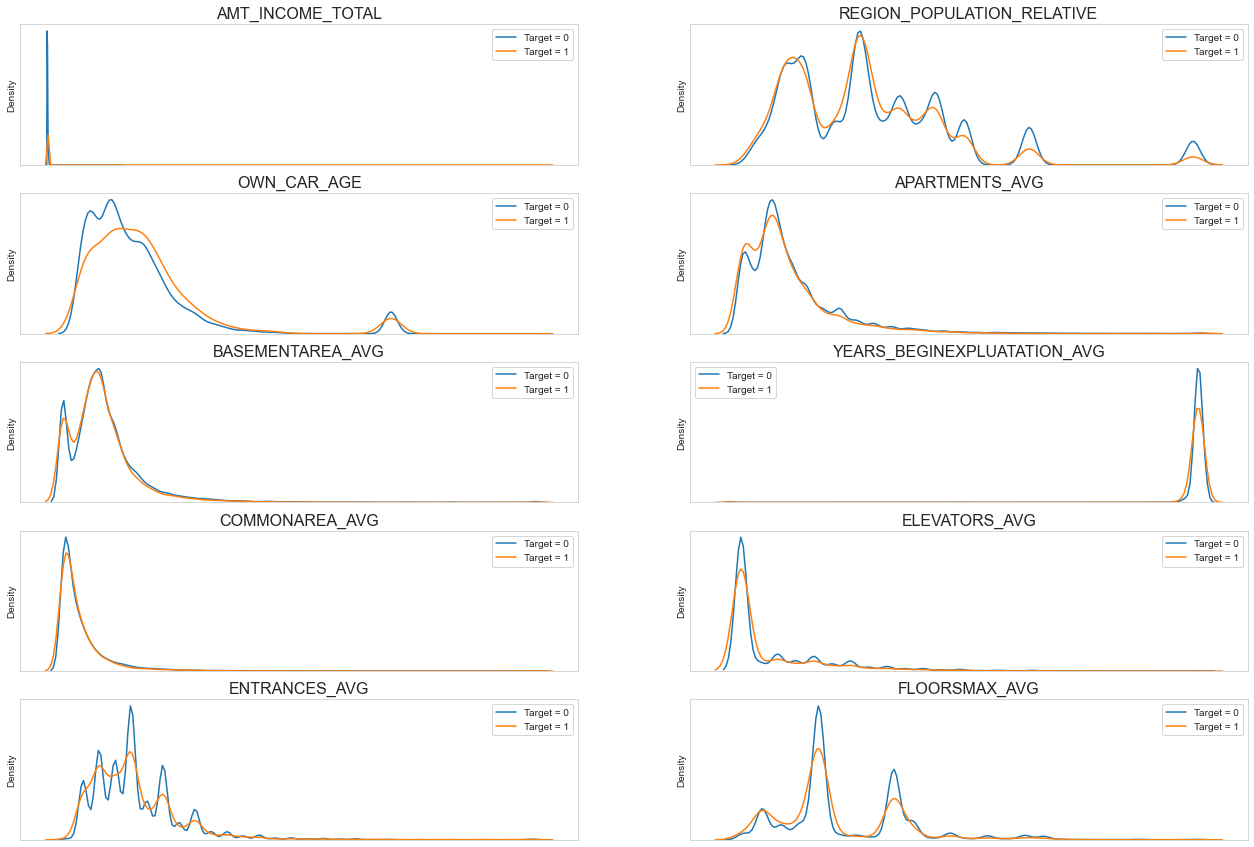

In [24]:
# Another 10 float-format variables 
float_variables = [i for i in float_variables if i not in variables_interest_float]
list_variables = float_variables[:10]

print('Another 10 float-format variables \n\n'.center(columns))
plot_numerical(list_variables, nrows = 5, ncols = 2)

**Insights**:

- None of this variables appear to have predictability power. There isn't any notable difference in the  distribution in both defaulted and non-defaulted loans.
- AMT_INCOME TOTAL has a concentrate distribution in the lower tail. This phenomena appear when dealing with nominal values. For example if we plot the income of a random population, the majority of incomes will reside within an statistical neighbor. However if a person earns more than the general population, it will disturb the distribution by adding more variance.
- Outlier detection may be require for the variables with a lower concentration distribution. 

### Categorial distribution variables <a class="anchor" id="categorical"></a>

Similar to the float variables, this columns were hand-picked for the same reason.

In [25]:
categorial_variables = ['CODE_GENDER',                      
                        'FLAG_OWN_CAR',                     
                        'FLAG_OWN_REALTY',
                        'NAME_TYPE_SUITE',                  
                        'NAME_INCOME_TYPE' ,                
                        'NAME_EDUCATION_TYPE',              
                        'NAME_FAMILY_STATUS',               
                        'NAME_HOUSING_TYPE',
                        'OCCUPATION_TYPE',
                        'WEEKDAY_APPR_PROCESS_START',
                        'ORGANIZATION_TYPE',
                        'WALLSMATERIAL_MODE',               
                        'EMERGENCYSTATE_MODE']

Now that we've a list with all categorical values, we only chose four aiming to explain the default problem

In [26]:
variables_interest_categorical = ['CODE_GENDER',
                                  'NAME_INCOME_TYPE',
                                  'NAME_EDUCATION_TYPE',
                                  'NAME_FAMILY_STATUS']

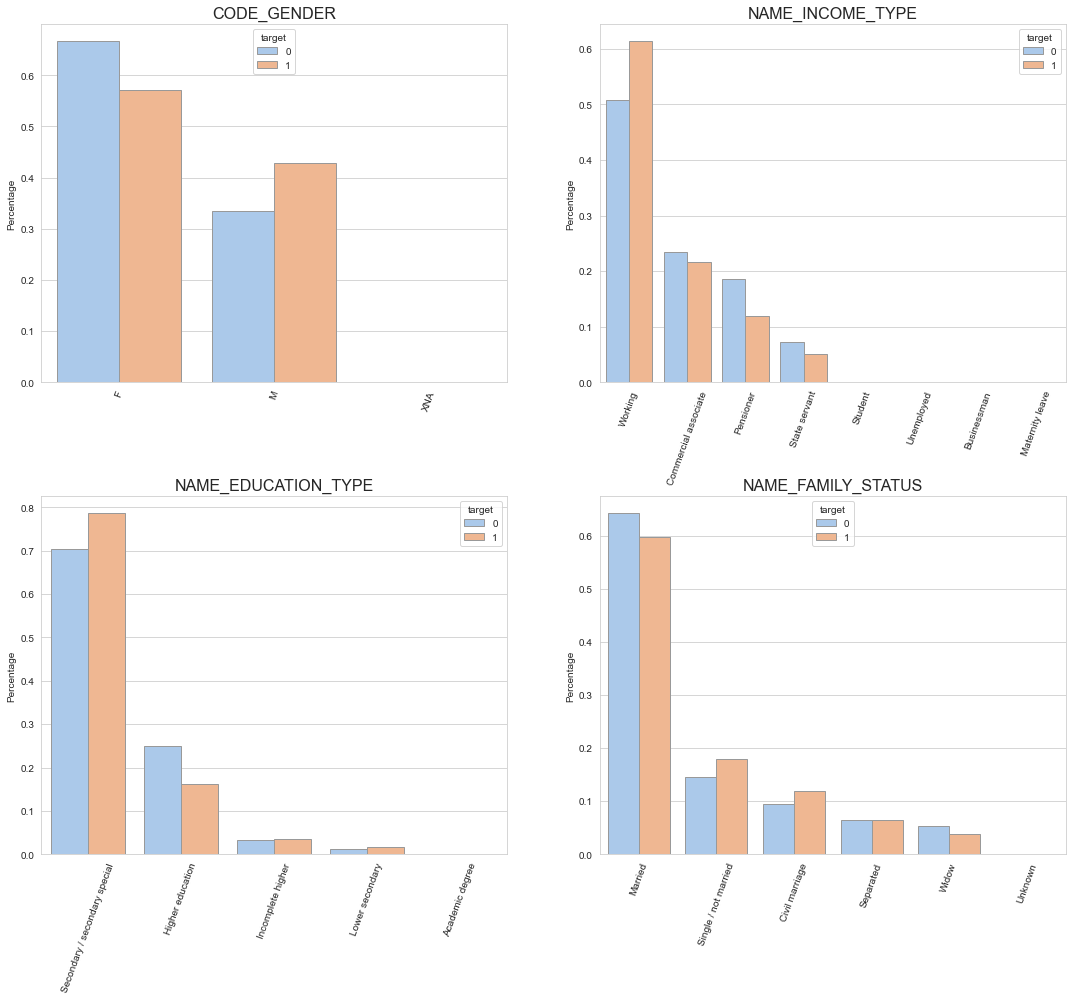

In [27]:
plot_categorical(variables_interest_categorical, many_categories = False, rotate_xlabel = True)

The sum of the percentage within a category doesn't add upp to 100%. For example, if we're viewing *Secondary / secondary special* subclass, the sum within this category adds upp to 150% (70% when target = 0 and 80% when target = 1). 
To clarify this, it's important to specify that the graph answer the following question:
                    
   - **If we take all the population that defaults the loan, ¿What percentage has completed highschool?** 
   
This mean that we've to add all the orange or blue bars in each graph to verify that it adds upp to 100%.

It was decided to implement this percentage graph rather than a count plot because we have an imbalanced data, so the majority class will domain all the graphs. However, if it's considered not only the number of records but also the total population of the class to calculate the percentage, we can if there is a difference.

**Insights**

- Later on this project we're going to aggregate some subclasses within each variable 
  (For example collect the subclasses: *Student*, *Unemployment*, *Businessman* and *Maternity leave* and create a new class      named *Others*)
- We can see differences in the distributions of the target variable among the variables, although they aren't marked.

Out of curiosity, I'm plotting the weekday were the loan process started and the type of wall material in the building

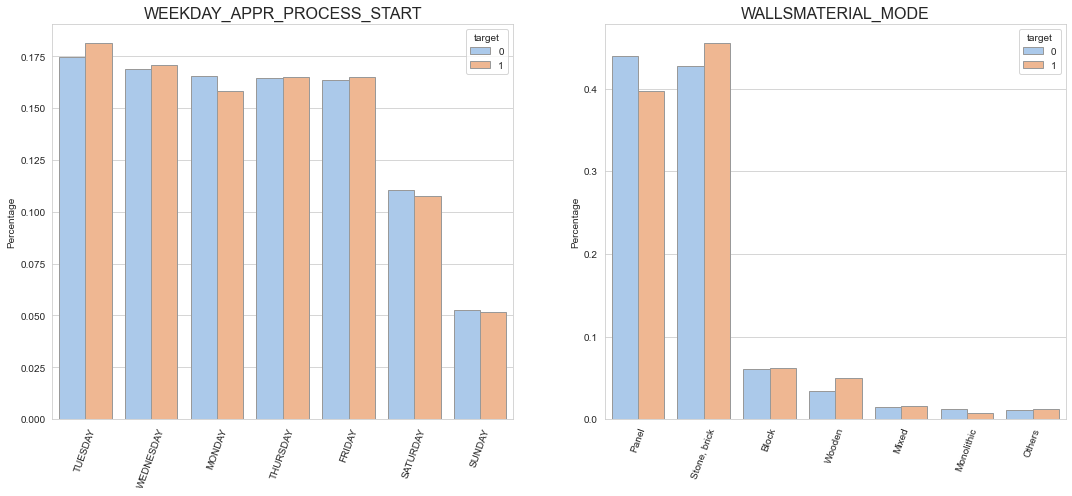

In [28]:
# 2 of Above
list_variables = ['WEEKDAY_APPR_PROCESS_START','WALLSMATERIAL_MODE']

plot_categorical(list_variables, many_categories = False, rotate_xlabel = True, nrows = 1, height = 7)

Luckly there isn't any difference in the distribution. Although it would have been hilarious to conclude that the loans lendered on friday are 2x more likely to default that the loans on Monday (obviously we aren't taking into account any latent feature).

There are two columns that have 10+ subcategories, namely *organization_type* and *occupation_type*.
I'm going to plot them to see if there is any significative difference

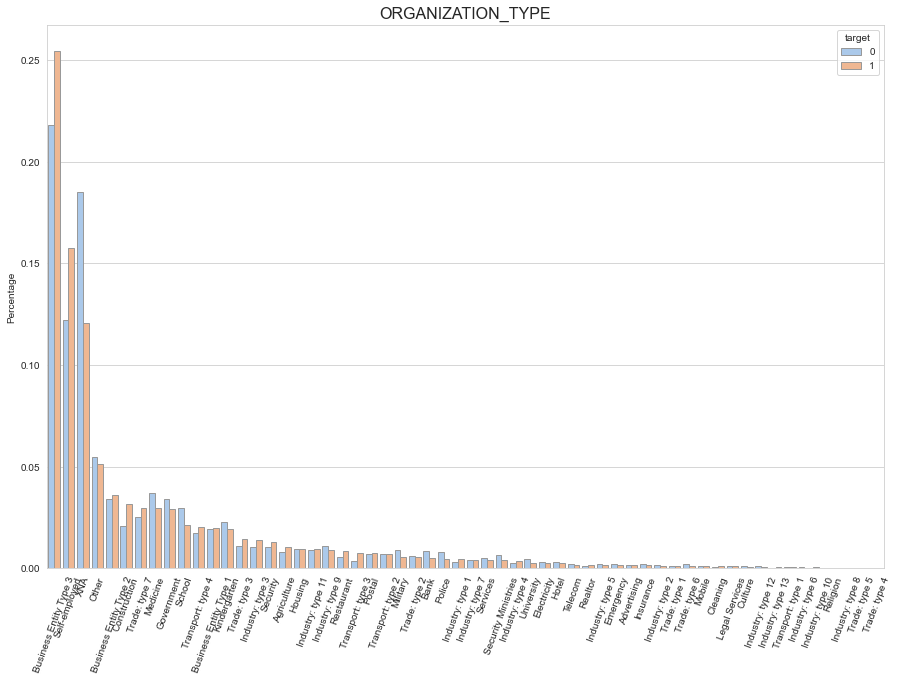

In [29]:
plot_categorical('ORGANIZATION_TYPE', many_categories = True)

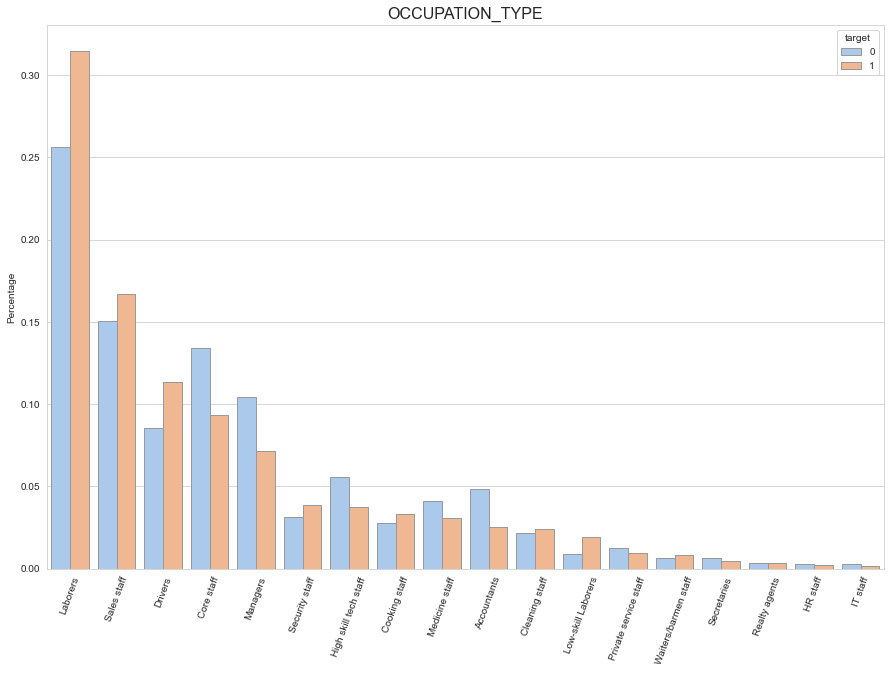

In [30]:
plot_categorical('OCCUPATION_TYPE', many_categories = True)

Even though there are some subclasses that have more than 5 basic points in differnte (taking the OCCUPATION_TYPE column, *laborers* has around 6 basic points), in this analysis, we're not taking OCCUPATION_TYPE or ORGANIZATION_TYPE as an explanatory variables.

### Integers variables <a class="anchor" id="int"></a>

After analysing both categorical and float variables, we arrived at the integer variables.

In [31]:
variable_integer = ['REG_REGION_NOT_LIVE_REGION',
                    'REG_CITY_NOT_LIVE_CITY',
                    'DAYS_EMPLOYED',
                    'DAYS_REGISTRATION',
                    'DAYS_BIRTH',
                    'DAYS_ID_PUBLISH',
                    'DAYS_LAST_PHONE_CHANGE',
                    'CNT_CHILDREN',
                    'CNT_FAM_MEMBERS',
                    'REGION_RATING_CLIENT']

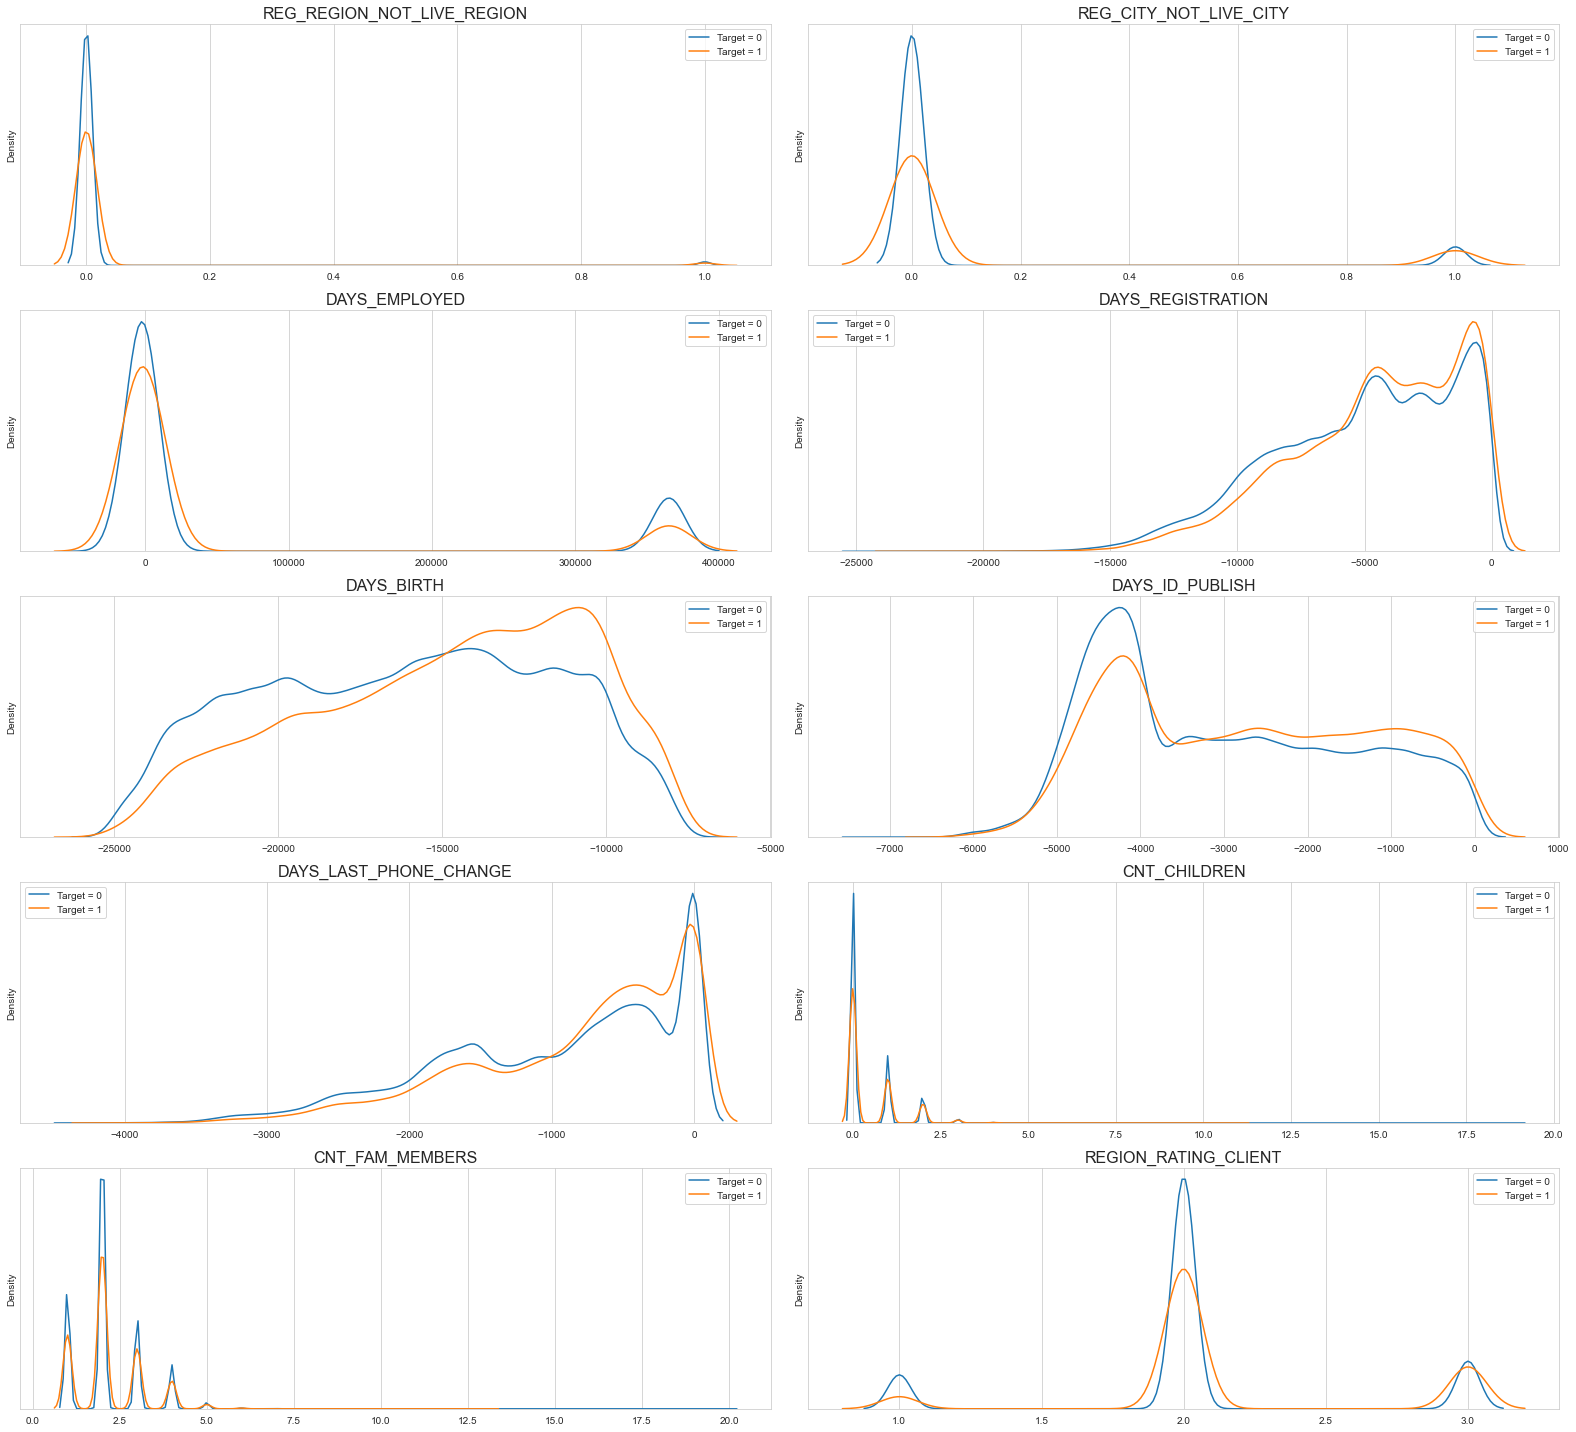

In [32]:
plot_integer(variable_integer)

**Insights**

- DAYS_BIRTH has negative values. Probably when this variable was calculated they applied the formula backwards. 
  (DATE_OF_LOAN - DATE_OR_BIRTH) has the same value that (DATE_OF_BIRTH - DATE_OF_LOAN) but with the opposite sign. Correction   is needed and it would be more understandable if the variable is in year rather than days.
- CNT_FAM_MEMBERS and CNT_CHILDREN could use an aggregation method to reduce the variance. 

## Correlations <a class="anchor" id="corr"></a>

Now that we've done the EDA, we're going to investigate some linear interactions among the variables.

Firstly, I reduce 122 variables to just 24. The reason behind is pretty simple: **parsimony**.
It's better for computational and understability purposes to have a simple but concise model than a gigantic and chaotic one.

Hence, a brief summary of the new data set is going to be provided

#### ID:

- **SK_ID_CURR**: ID of loan
- **NAME_CONTRACT_TYPE**: Identification if loan is cash or revolving

Initially, *NAME_CONTRACT_TYPE* wasn't a key to the dataframe. But after studying the data, it has to be a key because it's different the behavior and the client profile for, an example, a credit card (revolvent credit) or a mortgage. Hence, it's distinct to analyse the default of a revolvent credit that a no-revolvent credit

#### Variables of interest:

- **EXT_SOURCE_1:** Normalized score from external data source 1                 
- **EXT_SOURCE_2:** Normalized score from external data source 2          
- **EXT_SOURCE_3:** Normalized score from external data source 3
- **CODE_GENDER:** Gender of the client
- **AMT_ANNUITY**: Loan annuity
- **AMT_GOODS_PRICE:** For consumer loans it is the price of the goods for which the loan is given
- **AMT_INCOME_TOTAL:** Income of the client
- **AMT_CREDIT:** Credit amount of the loan
- **NAME_INCOME_TYPE:** Clients income type (businessman, working, maternity leave
- **NAME_HOUSING_TYPE:** ¿What is the housing situation of the client (renting, living with parents,...)?
- **NAME_EDUCATION_TYPE:** Level of highest education the client achieved
- **REG_REGION_NOT_LIVE_REGION:** Flag if client's permanent address does not match contact address (1=different, 0=same, at region                               level)
- **REG_CITY_NOT_LIVE_CITY:** Flag if client's permanent address does not match contact address (1=different, 0=same, at city                                 level)
- **DAYS_EMPLOYED:** ¿How many days before the application the person started current employment?
- **DAYS_REGISTRATION:** ¿How many days before the application did client change his registration?
- **DAYS_BIRTH:** Client's age in days at the time of application
- **DAYS_ID_PUBLISH:** ¿How many days before the application did client change the identity document with which he applied for the                     loan?
- **DAYS_LAST_PHONE_CHANGE:** ¿How many days before application did client change phone?
- **CNT_CHILDREN:** Number of children the client has
- **CNT_FAM_MEMBERS:** ¿How many family members does client have?
- **ENTRANCES_MEDI:** Normalized information about building

In [33]:
variables_of_interest = ['SK_ID_CURR',
                        'TARGET',
                        'NAME_CONTRACT_TYPE',
                        'EXT_SOURCE_1',                     
                        'EXT_SOURCE_2',                     
                        'EXT_SOURCE_3',
                        'CODE_GENDER',
                        'AMT_ANNUITY',
                        'AMT_GOODS_PRICE',
                        'AMT_INCOME_TOTAL',
                        'AMT_CREDIT',
                        'NAME_INCOME_TYPE',
                        'NAME_HOUSING_TYPE',
                        'NAME_EDUCATION_TYPE',
                        'REG_REGION_NOT_LIVE_REGION',
                        'REG_CITY_NOT_LIVE_CITY',
                        'DAYS_EMPLOYED',
                        'DAYS_REGISTRATION',
                        'DAYS_BIRTH',
                        'DAYS_ID_PUBLISH',
                        'DAYS_LAST_PHONE_CHANGE',
                        'CNT_CHILDREN',
                        'CNT_FAM_MEMBERS',
                        'ENTRANCES_MEDI']

Now we create the new dataset as a subset of *application_train*

In [34]:
df_train = application_train.loc[:,variables_of_interest]
df_train = df_train[df_train.CODE_GENDER != 'XNA']

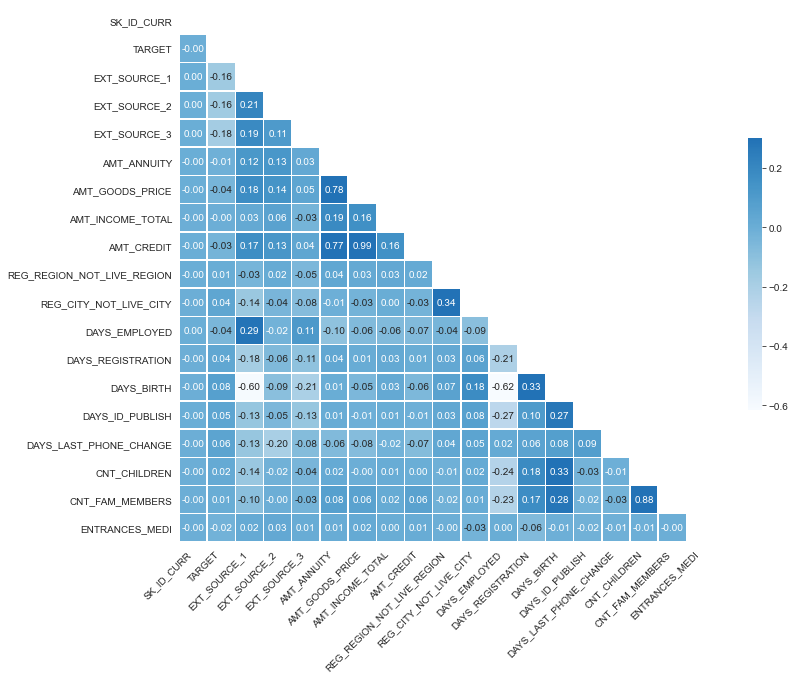

In [35]:
corr = df_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool));
f, ax = plt.subplots(figsize=(12, 10));

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Blues', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = '.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

**Insights**

- As expected, EXT_SOURCE variables has the most linear relation with TARGET. Although the maximum value is 0.18, so we cannot   state the interaction is strong.


- AMT_CREDIT and AMT_GOOD_PRICE have a correlation of 0.99. Reviweing the description is logical to think that these variables   are going to be correlated. AMT_CREDIT is the amount of the loan and AMT_GOOD_PRICE is the price of the good for the loan.
  Evendough they aren't equal, they are telling the same history. For example, in Colombia, if I want to buy a 100k house, the 
  AMT_CREDIT variable would have a limit of 70k (it ins't permitted to leverage more than a 70% of the price). So, if the price 
  of the good increises, the credit amount increases as well (it isn't always the case but with a correlation of 0.99, it isn't
  foolish to claim that)
  
  
- With the same idea behind in the previous point, CNT_CHILDREN and CNT_FAM_MEMBERS have a similar relation.

### Union train and test sets for feature engineering 

In [36]:
application_test.loc[:,'TARGET'] = None

In [37]:
df_test = application_test.loc[:,variables_of_interest]

In [40]:
df = pd.concat([df_train,df_test])

### Missing values <a class="anchor" id="missing_values"></a>

In [41]:
df.isnull().sum(axis = 0) * 100 / df.shape[0]

SK_ID_CURR                     0.000000
TARGET                        13.682488
NAME_CONTRACT_TYPE             0.000000
EXT_SOURCE_1                  54.430163
EXT_SOURCE_2                   0.187508
EXT_SOURCE_3                  19.546050
CODE_GENDER                    0.000000
AMT_ANNUITY                    0.010105
AMT_GOODS_PRICE                0.078035
AMT_INCOME_TOTAL               0.000000
AMT_CREDIT                     0.000000
NAME_INCOME_TYPE               0.000000
NAME_HOUSING_TYPE              0.000000
NAME_EDUCATION_TYPE            0.000000
REG_REGION_NOT_LIVE_REGION     0.000000
REG_CITY_NOT_LIVE_CITY         0.000000
DAYS_EMPLOYED                  0.000000
DAYS_REGISTRATION              0.000000
DAYS_BIRTH                     0.000000
DAYS_ID_PUBLISH                0.000000
DAYS_LAST_PHONE_CHANGE         0.000281
CNT_CHILDREN                   0.000000
CNT_FAM_MEMBERS                0.000561
ENTRANCES_MEDI                50.078737
dtype: float64

**Conclusion of missing values**

- The variables that have the most correlation with TARGET also have missing values. We cannot drop the rows without any data     because we'll be dropping 56% of the data. Its decided that for EXT_SOURCE the null values will be filled with -1


- Even dough ENTRANCE_MEDI have 50% of missing data and a correlation of -0.02, i'll wait for the model to drop this variable.
  In the meantime, I will inplaced -1 for the missing values


- AMT_ANNUITY, AMT_GOODS_PRICE, DAYS_LAST_PHONE_CHANGE, CNT_FAM_MEMBERS have less than 1% missing data, so it isn't harmful to inpute them with the median.

To clarify, the inputation of -1 for missing values doesn't affect the variable because the values varies from 0 and 1

In [42]:
row_list = ['CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE','AMT_GOODS_PRICE','AMT_ANNUITY']
for i in row_list:
    median = df[i].median()
    df.loc[df[i].isnull() == True,i] = median

In [43]:
to_clean = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','ENTRANCES_MEDI']

for var in to_clean:
    df.loc[:,var] = df[var].fillna(-1)

In [44]:
df.isnull().sum(axis = 0) * 100 / df.shape[0]

SK_ID_CURR                     0.000000
TARGET                        13.682488
NAME_CONTRACT_TYPE             0.000000
EXT_SOURCE_1                   0.000000
EXT_SOURCE_2                   0.000000
EXT_SOURCE_3                   0.000000
CODE_GENDER                    0.000000
AMT_ANNUITY                    0.000000
AMT_GOODS_PRICE                0.000000
AMT_INCOME_TOTAL               0.000000
AMT_CREDIT                     0.000000
NAME_INCOME_TYPE               0.000000
NAME_HOUSING_TYPE              0.000000
NAME_EDUCATION_TYPE            0.000000
REG_REGION_NOT_LIVE_REGION     0.000000
REG_CITY_NOT_LIVE_CITY         0.000000
DAYS_EMPLOYED                  0.000000
DAYS_REGISTRATION              0.000000
DAYS_BIRTH                     0.000000
DAYS_ID_PUBLISH                0.000000
DAYS_LAST_PHONE_CHANGE         0.000000
CNT_CHILDREN                   0.000000
CNT_FAM_MEMBERS                0.000000
ENTRANCES_MEDI                 0.000000
dtype: float64

With the data cleaned, now we can do some feature engineering

### Feature Engineering <a class="anchor" id="feature_engineering"></a>

**Narrowing the variance of existing variables**

In the next line were're condensing the distribution. 
- For *ANT_INCOME_TOTAL* the maximum value is 472.500 rather than 117.000.000
- The maximum value for *AMT_ANNUITY* was 258.025, and now 70.006

In [45]:
max_income = df.AMT_INCOME_TOTAL.max()
max_income_no_outlier = np.percentile(df.loc[df.AMT_INCOME_TOTAL != df.AMT_INCOME_TOTAL.max(),'AMT_INCOME_TOTAL'],99)
df.loc[df.AMT_INCOME_TOTAL > max_income_no_outlier,'AMT_INCOME_TOTAL'] = max_income_no_outlier

In [46]:
max_annutiy = np.percentile(df.loc[:,'AMT_ANNUITY'],99)
df.loc[df.AMT_ANNUITY > max_annutiy,'AMT_ANNUITY'] = max_annutiy

**New variables**

Taking advantage of the fact that *EXT_SOURCE* is a positive number between 0 and 1. If we apply transformation such as square or square root, the value will be 'push' to the limits either 0 or 1. Doing so, it'll create variables with hopefully more statistical significance.

In [47]:
row_list = ['1','2','3']
for i in row_list:
    
    df.loc[:,'EXT_SOURCE_' + i + '_SQ'] = df['EXT_SOURCE_' + i].apply(lambda x: -1 if x == -1 else x ** 2)
    df.loc[:,'EXT_SOURCE_' + i + '_SQRT'] = df['EXT_SOURCE_' + i].apply(lambda x: -1 if x == -1 else math.sqrt(x))

In [48]:
df.loc[:,'ENTRANCE_MEDI_SQ'] = df['ENTRANCES_MEDI'].apply(lambda x: -1 if x == -1 else x ** 2)
df.loc[:,'ENTRANCE_MEDI_SQRT'] = df['ENTRANCES_MEDI'].apply(lambda x: -1 if x == -1 else math.sqrt(x))

We have *AMT_INCOME_TOTAL* and *DAYS_BIRTH*, so let's take percentages!

In [49]:
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['PRICE_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
df['CREDIT_PRICE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['CREDIT_LENGTH'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

df['INCOME_EMPLOYED_RATIO'] = np.where(df['DAYS_EMPLOYED'] == 0, 0, df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED'])
df['EMPLOYED_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['PUBLISH_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['EMPLOYED_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['CHILDREN_FAM_RATIO'] = np.where( df['CNT_FAM_MEMBERS'] == 0, 0, df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS'])

**Fixing existing variables**

There are some categorical variables with subcategories that aren't worth seeing each one independently. So we're going to group this one in one category named *Others*

In [50]:
row_list = ['AMT_INCOME_TOTAL','AMT_ANNUITY','AMT_GOODS_PRICE', 'AMT_CREDIT']

for i in row_list:
    df.loc[:,i] = df[i].apply(lambda x: np.log(x))

In [51]:
row_list = []
for i in df.NAME_INCOME_TYPE:
    if ((i == 'Unemployed') | (i == 'Maternity leave') | (i == 'Student') | (i == 'Businessman')):
        row_list.append('Other')
    else:
        row_list.append(i)  

df.loc[:,'NAME_INCOME_TYPE'] = row_list

In [52]:
row_list = []
for i in df.NAME_HOUSING_TYPE:
    if ((i == 'Municipal apartment') | (i == 'Rented apartment') | (i == 'Rented apartment') | (i == 'Co-op apartment')):
        row_list.append('Other')
    else:
        row_list.append(i)  

df.loc[:,'NAME_HOUSING_TYPE'] = row_list

In [53]:
row_list = []
for i in df.NAME_EDUCATION_TYPE:
    if ((i == 'Incomplete higher') | (i == 'Lower secondary')):
        row_list.append('Other')
    else:
        row_list.append(i)  

df.loc[:,'NAME_EDUCATION_TYPE'] = row_list

As stated before, it makes more sense to say 36 years old than 13.140 days since birth. In the next cell we're transforming all the *DAYS* variables to year format

In [54]:
row_list = ['DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']

for i in row_list:    
    df.loc[:,i] = df[i].apply(lambda x: (x * (-1))/ 365)

There are some clients who, according to *DAYS_EMPOYED* have been working for a 1.000 years. I'm not buying it. Unfortunately these typo repeated many times in the dataframe, so I imputed a maximum value of 50 years working for this customers.

In [55]:
df.loc[df.DAYS_EMPLOYED > 0,'DAYS_EMPLOYED'] = 50

In this remaining two cells, we're shortening the distribution by condensating all clients that have more than 4 children in 4 or those who have more than 6 family members in 6.

In [56]:
df.loc[df.CNT_CHILDREN >= 4,'CNT_CHILDREN'] = 4

In [57]:
df.loc[df.CNT_FAM_MEMBERS >= 6,'CNT_FAM_MEMBERS'] = 6

## Modeling <a class="anchor" id="modeling"></a>

#### Dummies <a class="anchor" id="dummies"></a>

In [58]:
df = pd.get_dummies(df,
                        columns=['NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','NAME_INCOME_TYPE','NAME_CONTRACT_TYPE','CODE_GENDER'])

In [59]:
print('A total of {} variables will be used in the model'.format(len(df.columns)))

A total of 52 variables will be used in the model


#### Train and test split the data <a class="anchor" id="train_test"></a>

Getting back training and predicting dataframe 

In [61]:
train = df_train.shape[0]
test = df_test.shape[0]

df_train = df.loc[df.TARGET.notnull() == True,:]
df_test = df.loc[df.TARGET.notnull() == True,:]

df_test = df_test.loc[:,df_test.columns != 'TARGET']

In [62]:
X = df_train.loc[:,~df_train.columns.isin(['TARGET','SK_ID_CURR'])]
Y = df_train.loc[:,'TARGET'].astype(int)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20)

In [64]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Target Shape:', y_test.shape)

Training Features Shape: (246005, 50)
Training Target Shape: (61502, 50)
Testing Features Shape: (246005,)
Testing Target Shape: (61502,)


### Training <a class="anchor" id="training"></a>

For computational reasons (working locally), only one algorithm is going to be tested and is a **Random Forest**.

Hiperparameter tunning was performed with the following parameters:

 * **n_estimators**: [200, 400, 600, 800, 1000],
 * **max_features**: ['auto', 'sqrt'],
 * **max_depth**: [100, 140, 180, 220, 260, 300],
 * **min_samples_split**: [2, 5, 10],
 * **min_samples_leaf**: [1, 2, 4],
 * **bootstrap**: [True, False]
 
Sadly, due to the fact that we're working locally, the grid search had to be stopped after 8 running hours.
Fortunately, Cross Validation was perfomed so we can check if the metrics values are consistend across multiples samplinf of the training data

To verify our model performance, the first criteria is **Area Under the Curve (AUC)**

I'm going to briefly explain the AUC value in a business context. This explanation is not going to be a tecnical, rather a 'chatting' approach.

When the model is fitted and we have the prediction for the target variable, the result isn't a binary response, it's a probabilistic. So the output of predicting a loan is 0.2 rather than 1 or 0.

We can't email the business all this probabilities because they care whetever a client will default or not.

¿How on earth are we going to decide the treeshold where we classify a client to be risky (possibly future default)?
This is the part where AUC enters the game. 

Regarding the confusion matrix, we have 4 types of outcomes in the prediction:

- My prediction is correct (Whenever is 1 or 0)
- My prediction is not correct:
 - My prediction said the client is not going to default but in reality this client defaulted (False negative)
 - My prediction said the client is going to default but in reality this client didn't default (False positive)
 
Depending of the treeshold, these numbers will vary. So a way of see this variation is by the ROC curve. ROC curve defines the ratio between two variables:

- Over all the people who defaulted, ¿How many did my model accurately predict?
- Calculate the ratio of the number of clients my model said they were not going to default they didn't defaulted over all the client who defaulted. After that we calculate (1 - ratio).


After plotting this ratio over many treeshold values, we have a graph similar to 

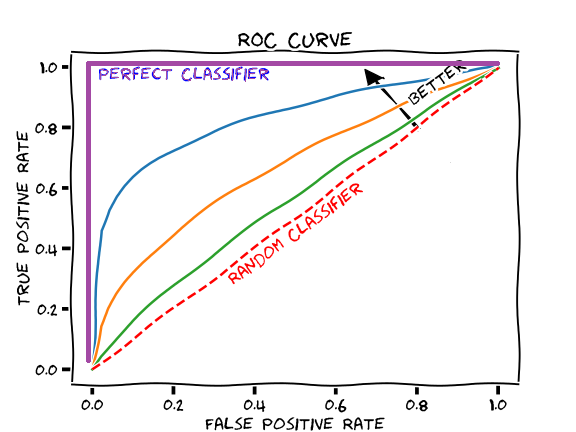

In [65]:
Image('ROC_curve.png')

The AUC value is simply the Area Under de Curve of this line.
 
An **AUC of 0.5** is a model that flip a coin to guess whetever the client isn't going to repay.

An **AUC of 1** implies that I correctly predicts all the loans.

The second criteria is **Mean Absolute Error (MAE)**

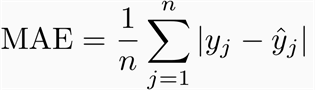

In [66]:
Image("MAE.gif")

Let dive-in in the possible values for the MAE in this project:

- The worst model is the model that mispredicts every loan. To this model, the corresponding value would be:

  (y_i - y_i_hat) is always going to be one because I failed to predict every loan, so the **MAE would be 1**


- The best model (I correctly predict every loan) has a **MAE of 0**

In [67]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, verbose = 1, n_jobs = -1)

In [68]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 71.0min finished


RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42, verbose=1)

Cross validation is going to be performed to verify that across subsets of the data AUC maintains a similar value

In [69]:
rf_cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 46.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.9min
[Parall

**Mean Absolute Value**

In [72]:
prediction = rf.predict(X_test)
errors = abs(prediction - y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   12.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   15.5s finished


In [73]:
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.15


**AUC**

In [74]:
print("=== AUC Scores for each fold ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

=== AUC Scores for each fold ===
[0.71326029 0.71984603 0.71567166 0.71405925 0.71552495]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7156724365671226


Viewing that the AUC scores is similar across de folds, we can stated that the AUC of the model (mean across the AUC for each fold) is 0.71

### Feature importance <a class="anchor" id="feature_importance"></a>

- ¿What variables contributed the most? 

In [81]:
# Most important features in the model
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:50} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DAYS_REGISTRATION                                  Importance: 0.07
Variable: DAYS_BIRTH                                         Importance: 0.06
Variable: CREDIT_LENGTH                                      Importance: 0.06
Variable: DAYS_ID_PUBLISH                                    Importance: 0.05
Variable: DAYS_LAST_PHONE_CHANGE                             Importance: 0.05
Variable: INCOME_EMPLOYED_RATIO                              Importance: 0.05
Variable: EMPLOYED_BIRTH_RATIO                               Importance: 0.05
Variable: PUBLISH_BIRTH_RATIO                                Importance: 0.05
Variable: EXT_SOURCE_2                                       Importance: 0.04
Variable: AMT_ANNUITY                                        Importance: 0.04
Variable: EXT_SOURCE_2_SQ                                    Importance: 0.04
Variable: EXT_SOURCE_2_SQRT                                  Importance: 0.04
Variable: CREDIT_INCOME_RATIO                                Imp

**Insights**

- Within the TOP 5 most important variables, 4 are related to longevity. So it's interesting because it may indicate that the default phenomena is time-related.

- The creation of variables was not a waste of time. Following the top five features are three variables created with: client's income, days as an employee, and the client's age. 

Now let plot these variables importance

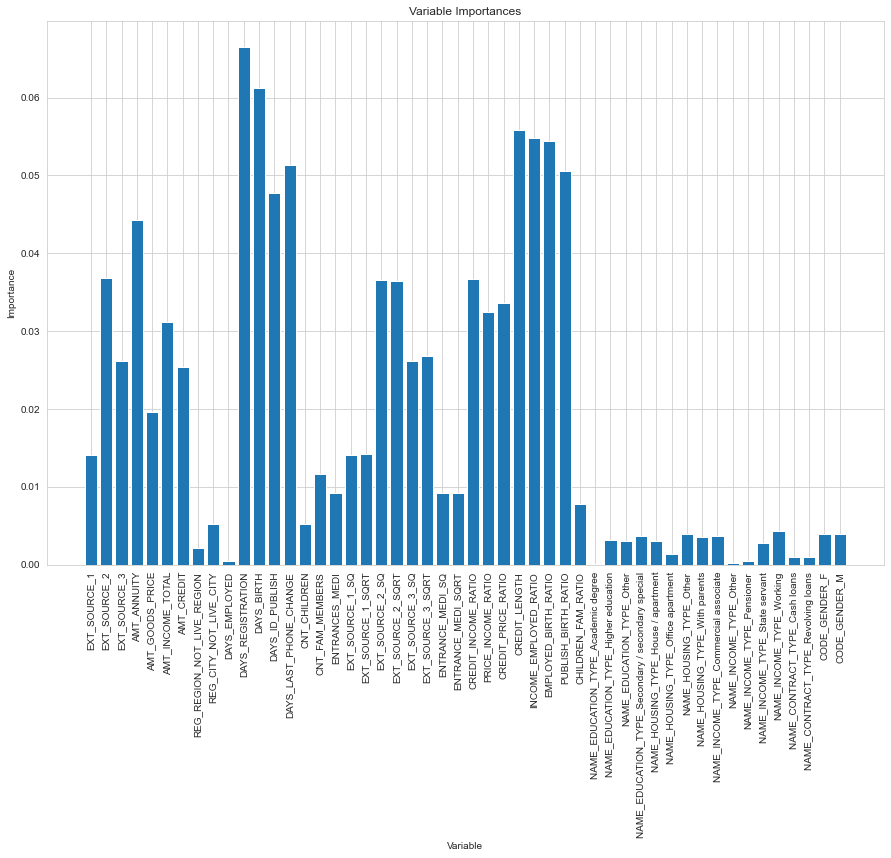

In [82]:
plt.figure(figsize = (15,10))

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, X.columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Conclusions <a class="anchor" id="conclusions"></a>

Taking into account that identyfing risky loans is a very difficult task due to highly imbalanced data (it isn't normal that a credit establisment has more than 9% of his portfolio in default. Probably there are laws against this type of extreme situation) the model didn't have a bad performance. An AUC value of 0.7 (mean of all CV AUC's) and a MAE of 0.15 will still be good results. 

In statistic,  these values are mediocre, but, in the business it would add value compared to a no-model escenario. I'm going to prove it with a tought experiment.
A MAE of 0.15 with this exercises means that we mispredict 15% of the records. Suppose that we found that in our top 1% (organizing the probabilities in descent order) there is a probability of 20% to find the default users. Let's some math:

 -  20% user in top 1% is the 0,2% of the overall population, that means 740 users. So far so good.
 
 -  Now the average credit amount for a user in the dataset is  454.760 (¿rupees?).
 
 -  So we're identifying an amount of 740 * 454.760 = 343 M by using this model. What happens next depends on how the company prevents this credit to default (via re-estructuration of the credit like increasing the duration).
 
 
As a conclusion, in statistical terms, the model isn't good but in business terms, it would have identify 343M in credit loans that are prone to default. In other terms, it means 343M more compared to a model that I predict nobody is going to default (in fact, this no-model model would have better statistical metrics but will lack any value for the business).

## Resources <a class="anchor" id="resources"></a>

- Koehrsen, W. (2018, January 17). Random forest in python. [Source](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)

- Ayman , Omar (2021, Febrery 26). EDA + predictive modelling. [Source](https://www.kaggle.com/omarayman/eda-predictive-modelling#Getting-data)

- VenkateshThota (2020, August 26). Santander Customer Transaction. [Source](https://www.kaggle.com/venkateshthota/santander-customer-transaction)

- Huneycutt, Jake (2018, May 21). Implementing a Random Forest Classification Model in Python. [Source](https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652)